# Replicating Gniadecka et al.'s paper

Actually from: "A simple background elimination method for Raman spectra" by Seong-Joon Baek et al.

In [220]:
import scipy.io as scio
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
import numpy as np 
from numpy import gradient
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
import pandas as pd

In [221]:
data = scio.loadmat('../Data/tissue3_1.mat')
calibration = scio.loadmat('../Data/cal_14.mat')

## 1. Background suppression

<b>Calculate the local first derivative of each spectrum. </b>

The derivatives of the fluorescence background are always smaller in magnitude than those of Raman peaks. Taking the derivative of a measured Raman spectrum will eliminatethe background components irrespective of their magnitudes and thus enhance the sharp Raman signal. However, high-frequency noises are often amplified by this method as well and the spectrum can be distorted because of the derivative process. The distortion causes the derivative spectrum to be different from the original spectrum in appearance, which makes the interpretation of the derivative spectrum difficult.

In [222]:
### CONSTANTS & DATA ###
x = calibration['Cal'][0][0][0]
x = [item for sublist in x for item in sublist]
signal = data['map_t3'][50,50,:]
SG_WIN  = 61
MA_WIN  = 204 # Not 81
MA_WIN2 = 41

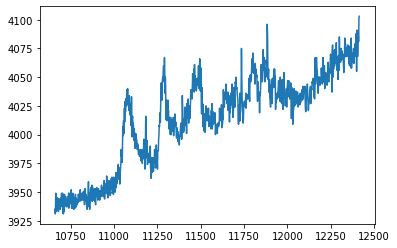

In [223]:
plt.plot(x, signal)

Seong-Joon's method:
SG -> derivative -> SG -> Running average x3

In [224]:
def moving_average(x, w, zero_pad=1):
    if zero_pad == 1:   
        a = np.zeros(int(w/2)-1) 
        z = np.zeros(int(w/2)) 
    else:
        a = np.ones(int(w/2)) * x[0]
        z = np.ones(int(w/2)) * x[-1]
        
    x = np.concatenate((a,x,z))
    return np.convolve(x, np.ones(w), 'valid') / w

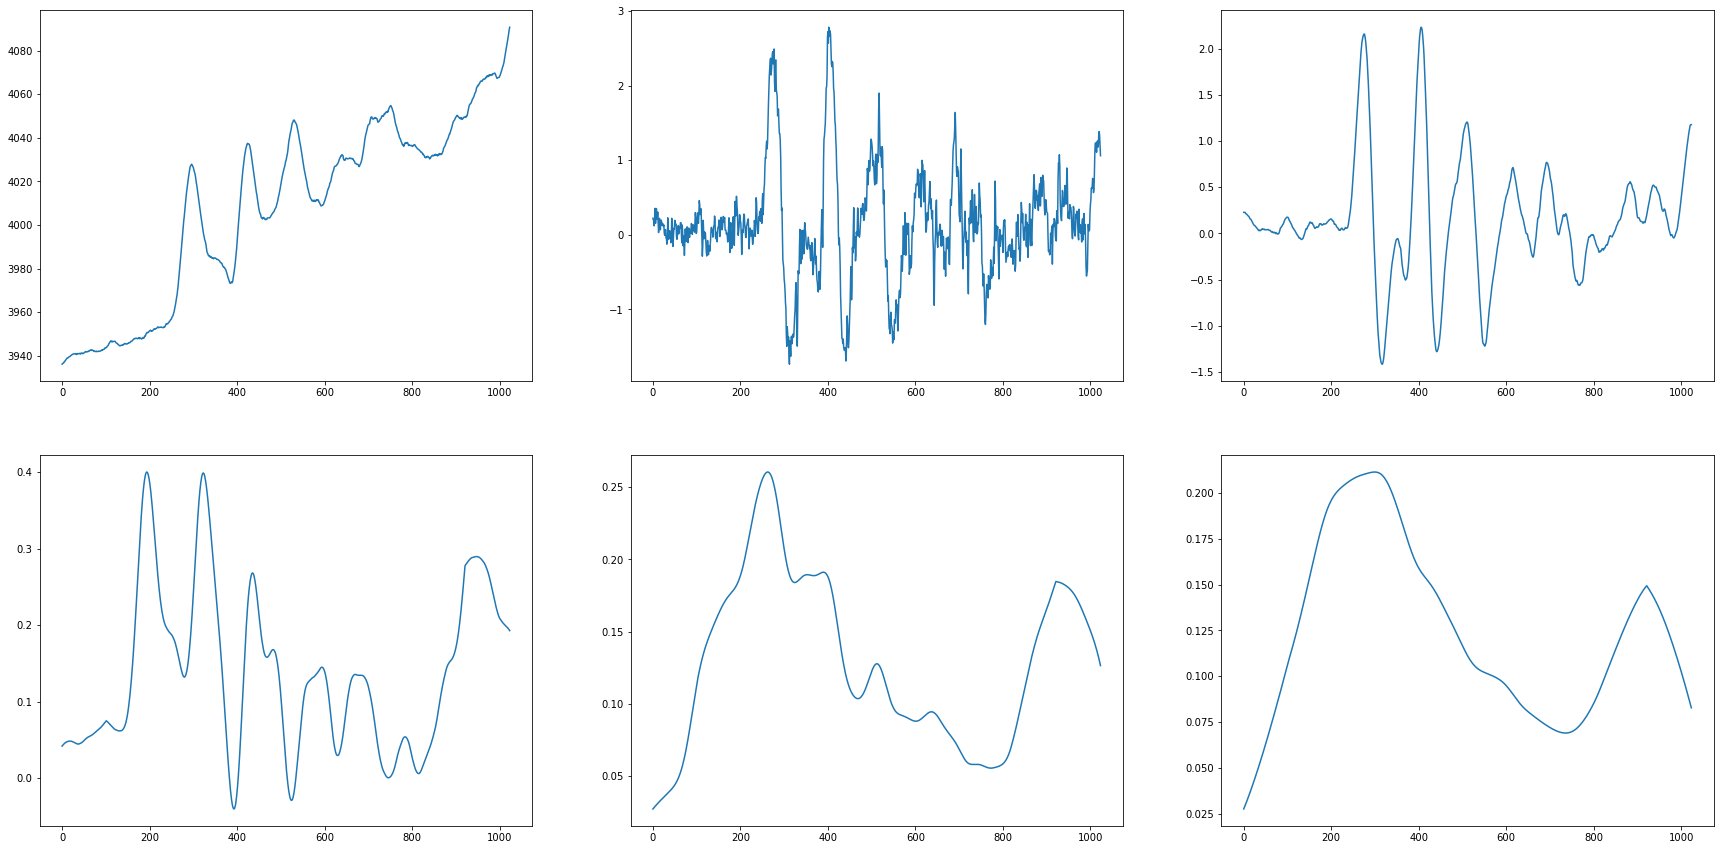

In [225]:
s_sg = savgol_filter(signal, SG_WIN, 2, mode='nearest')
s_dif = gradient(s_sg)
s_sg2 = savgol_filter(s_dif, SG_WIN, 2, mode='nearest')
s_ma1 = moving_average(s_sg2, MA_WIN)
s_ma2 = moving_average(s_ma1, MA_WIN)
s_ma3 = moving_average(s_ma2, MA_WIN)

fig, axs = plt.subplots(2,3, figsize=(30,15))
axs[0,0].plot(s_sg)
axs[0,1].plot(s_dif)
axs[0,2].plot(s_sg2)
axs[1,0].plot(s_ma1)
axs[1,1].plot(s_ma2)
axs[1,2].plot(s_ma3)

Remove baseline derivative contributions to obtain relevant derivative features (peaks)

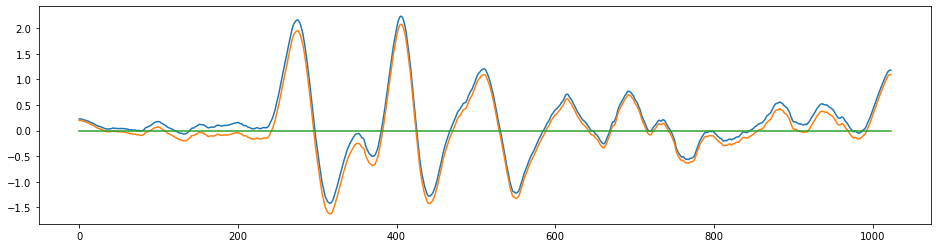

In [226]:
signal_derivative = s_sg2 - s_ma3
plt.figure(figsize=(16,4))
plt.plot(s_sg2)
plt.plot(signal_derivative)
array_0 = np.zeros(1024)
plt.plot(array_0)

Find peaks and their boundaries:
1. Peaks: sign of dg changes from + to −
2. Left boundary: find local maximum on the left of the peak. Then find local minimum position or the last position where dg is positive (above threshold)
3. Right boundary: find local minimum on the right of the peak. Then find local maximum position or the last position where dg is negative (below threshold)

In [227]:
peaks = []
peaks_y = []

for i in range(1023):
    if signal_derivative[i]>0 and signal_derivative[i+1]<0:
        x = [signal_derivative[i], signal_derivative[i+1]]
        y = [i,i+1]
        y_new = np.interp(0, x, y)
        
        peaks.append(y_new)
        peaks_y.append(0)

In [228]:
def left_boundary(signal, index):
    index = int(np.floor(index))
    if index == 0:
        return index
    
    # Find local maximum to left
    while signal[index-1]>signal[index]:
        index -= 1
        if index == 0:
            return index
    
    # Find last positive value or local minimum to left
    while signal[index]>0.001 and signal[index-1]<signal[index]:
        index -= 1
        if index == 0:
            return index
        
    return index

def right_boundary(signal, index):
    index = int(np.ceil(index))
    if index == 1023:
        return index
    
    # Find local minimum to right
    while signal[index+1]<signal[index]:
        index += 1
        if index == 1023:
            return index
    
    # Find last negative value or local maximum to left
    while signal[index]<-0.001 and signal[index+1]>signal[index]:
        index += 1
        if index == 1023:
            return index
        
    return index

In [229]:
left_boundaries = []
right_boundaries = []

for i in range(len(peaks)):
    lb = left_boundary(signal_derivative,peaks[i])
    rb = right_boundary(signal_derivative,peaks[i])
    left_boundaries.append(lb)
    right_boundaries.append(rb)

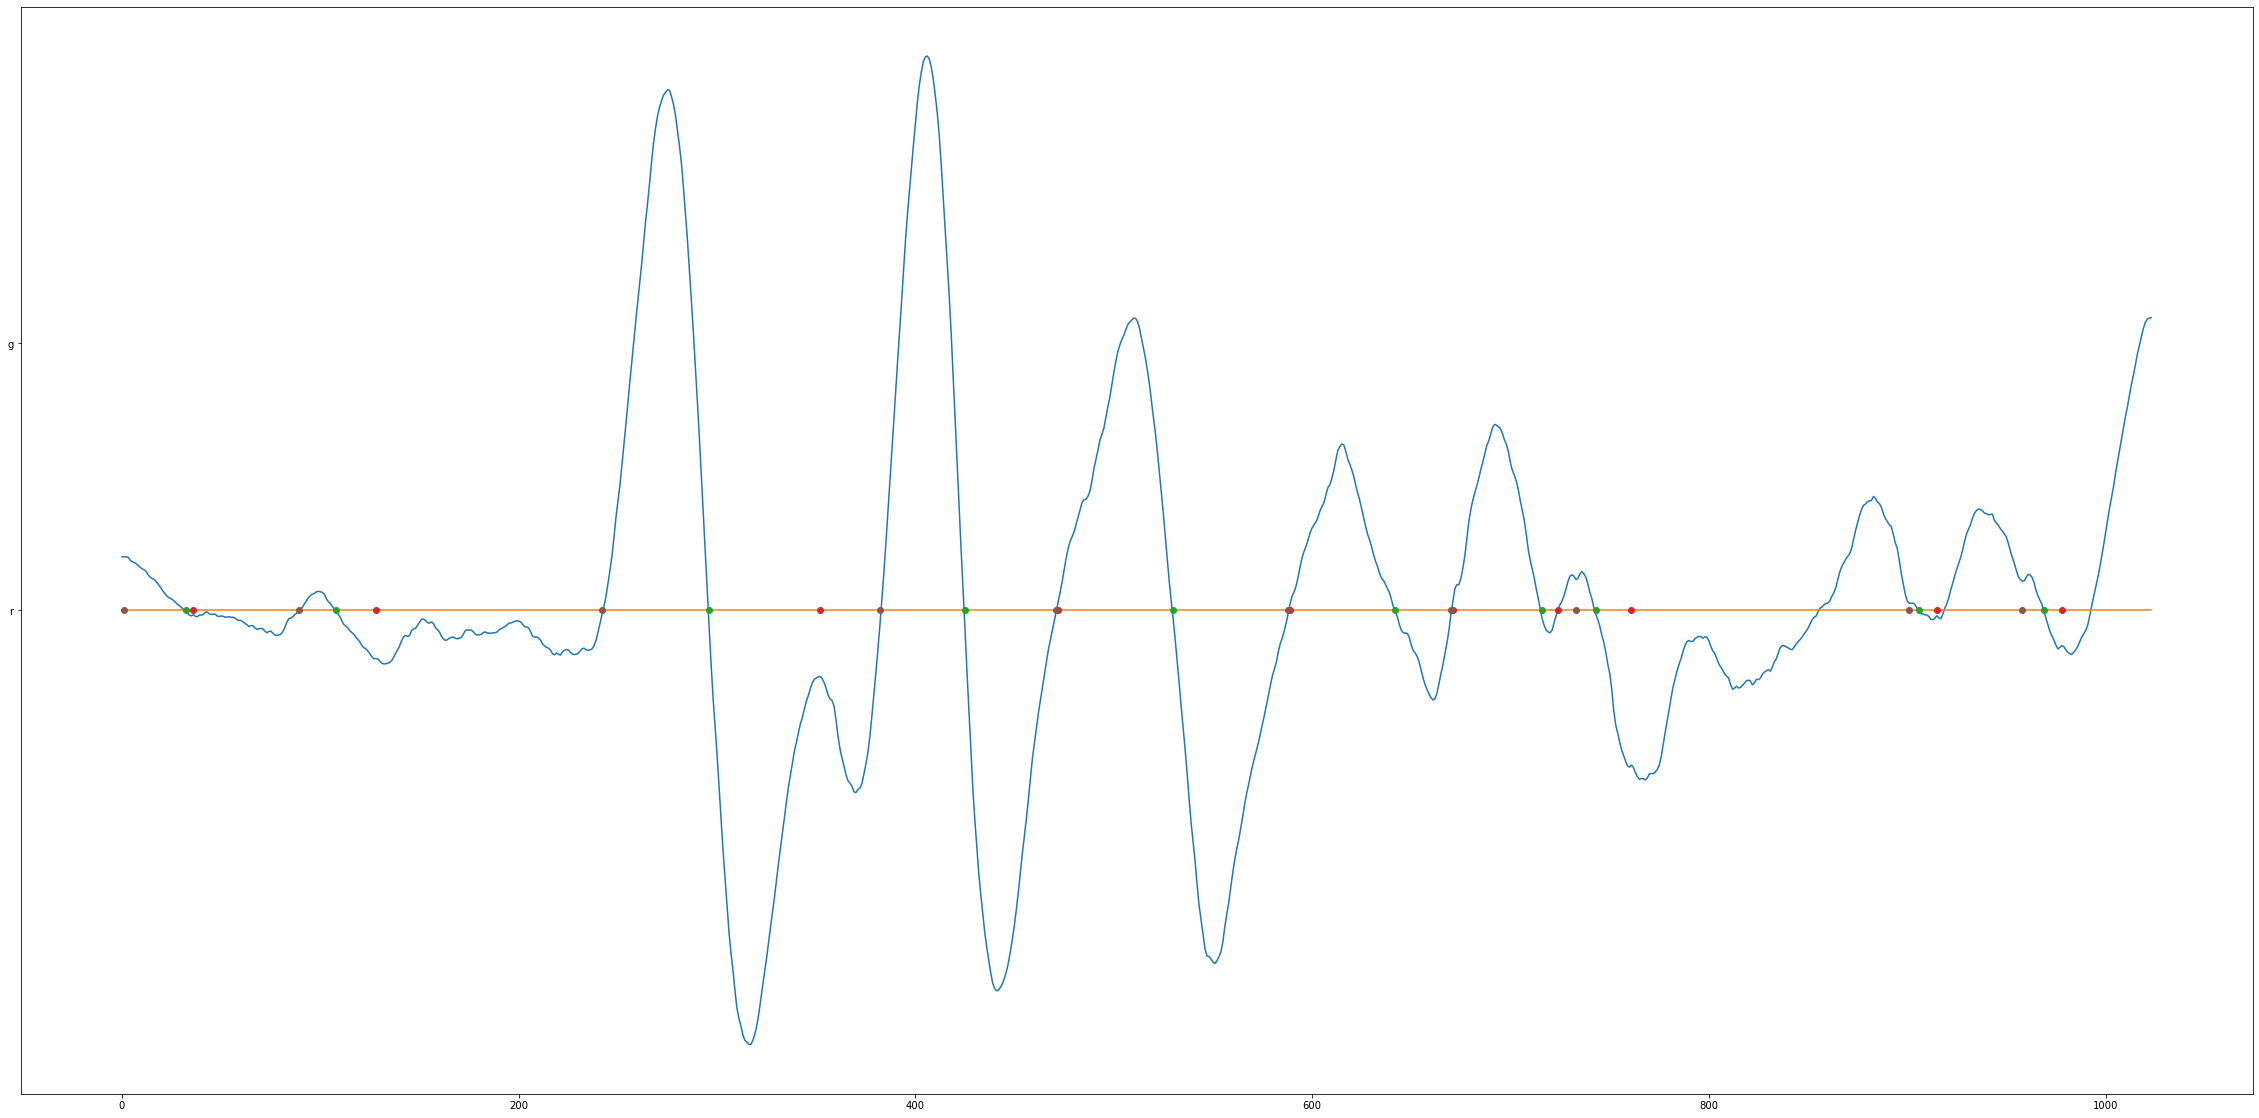

In [230]:
plt.figure(figsize=(40,20))
plt.plot(signal_derivative)
plt.plot(array_0)
plt.plot(peaks,peaks_y,'o')
lb_zeros = np.zeros(len(right_boundaries))
plt.plot(right_boundaries,lb_zeros,'o','r')
plt.plot(left_boundaries,lb_zeros,'o','g')

Remove peaks with small length between boundaries (considered not important)

In [231]:
count = 0
for i in range(len(peaks)):
    if right_boundaries[i-count]-left_boundaries[i-count] < 10:
        left_boundaries.pop(i-count)
        right_boundaries.pop(i-count)
        count += 1

Interpolate peaks: mix linear interpolation with integration of s_ma3

Avoid interpolation mismatch on boundaries: force cumulative sum to start from zero and end in zero (subtracting the mean from the derivative)

For each peak:
1. Subtract mean from s_ma3
2. Approximate integration with cumulative sum
3. Add results to linearly interpolated values

In [232]:
def cum_sum(x):
    count = 0
    for i in range(len(x)):
        count += x[i]
        x[i] = count
    return x

In [233]:
interpolated_peaks = signal.copy()

for i in range(len(left_boundaries)):
    l = left_boundaries[i]
    r = right_boundaries[i]
    
    peak = s_ma3[l:r]
    no_mean = peak - np.mean(peak)
    integrated = cum_sum(no_mean)

    x = [l,r]
    y = [signal[l], signal[r]]
    f = interp1d(x,y)
    
    count = 0
    while l+count < r:
        interpolated_peaks[l+count] = integrated[count] + f(l+count)
        count += 1

Smooth once more

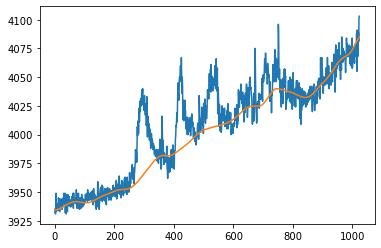

In [234]:
baseline = moving_average(interpolated_peaks, MA_WIN2, zero_pad=0)
baseline = moving_average(baseline, MA_WIN2, zero_pad=0)

plt.plot(signal)
plt.plot(baseline)

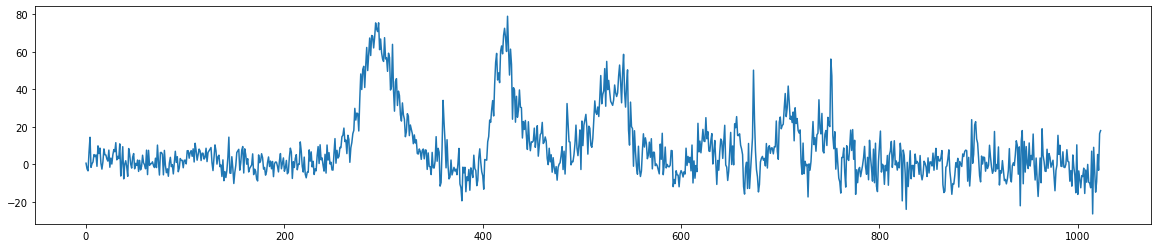

In [235]:
#minimum = np.min(signal-baseline,0)
final_result = signal-baseline

plt.figure(figsize=(20,4))
plt.plot(final_result)

## 2. PCA for dimensionality reduction

Use bayesian information criterion with the maximum likelihood formulation of PCA

In [236]:
from ipynb.fs.full.Gniadecka_functions import first_derivative_bl_removal

In [237]:
D = np.zeros((40000,1024))

for i in range(200):
    for j in range(200):
        index = i*200 + j
        signal = data['map_t14'][i,i,:]
        res,_ = first_derivative_bl_removal(x,signal,11,61,31)
        D[index,:] = res

KeyError: 'map_t14'

Normalise data

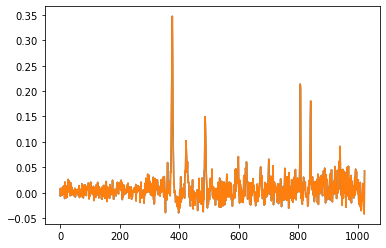

In [ ]:
norm_D = normalize(D)
plt.plot(D[0,:])
plt.plot(norm_D[0,:])

Use Maximum Likelihood Estimate to choose PCs in PCA

In [ ]:
pca = PCA(n_components='mle') 
pca.fit(D)
transformed = pca.transform(D)

## 3. Neural network for classification

In [ ]:
import sklearn.linear_model
import torch
import torch.nn as nn
import tqdm

In [ ]:
tissue = []

for i in range(40000):
    tissue.append((transformed))

In [ ]:
model = ConvolutionalNeuralNetwork(2)

for (data, target) in tissue:
    run_model(model, data,target,target.shape[0],target.shape[1])

## Tests

In [ ]:
import scipy.io as scio
tissue30 = scio.loadmat('../Data/tissue30.mat')
tissue31 = scio.loadmat('../Data/tissue31.mat')
tissue32 = scio.loadmat('../Data/tissue32.mat')
tissue33 = scio.loadmat('../Data/tissue33.mat')
tissue34_1 = scio.loadmat('../Data/tissue34_1.mat')
tissue34_2 = scio.loadmat('../Data/tissue34_2.mat')
tissue35 = scio.loadmat('../Data/tissue35.mat')
tissue36 = scio.loadmat('../Data/tissue36.mat')
tissue37 = scio.loadmat('../Data/tissue37.mat')
tissue38_1 = scio.loadmat('../Data/tissue38_1.mat')
tissue38_2 = scio.loadmat('../Data/tissue38_2.mat')
tissue39_1 = scio.loadmat('../Data/tissue39_1.mat')
tissue39_2 = scio.loadmat('../Data/tissue39_2.mat')
tissue40 = scio.loadmat('../Data/tissue40.mat')

all_tissues = [tissue30,tissue31,tissue32,tissue33,tissue34_1,tissue34_2,tissue35,tissue36,
               tissue37,tissue38_1,tissue38_2,tissue39_1,tissue39_2,tissue40]

In [ ]:
# Look at imported data
for item in all_tissues:
    bcc = False
    for key, value in item.items():
        if key == 'bcc':
            print(key, value.shape)
            bcc = True
    print(bcc)
    
        

bcc (200, 200)
True
bcc (400, 200)
True
False
False
bcc (200, 200)
True
bcc (200, 200)
True
False
bcc (200, 400)
True
bcc (200, 400)
True
False
False
bcc (200, 200)
True
False
False
